In [1]:
import tensorflow as tf
import os
import datetime
 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D,Activation,Dropout,Dense,Flatten
from tensorflow.keras.optimizers import Adam
from keras import backend as k
from keras import layers
import numpy as np
from keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.models import save_model, load_model

In [2]:
batch_size = 32 #32,128,256
epochs = 10

In [3]:
train_data_dir = ("train")
test_data_dir = ("test")

In [4]:
trainGen = ImageDataGenerator(rescale=1./255,shear_range=0.2,horizontal_flip=True,zoom_range=0.2)
 
testGen = ImageDataGenerator(rescale=1./255)
 
train = trainGen.flow_from_directory(train_data_dir,target_size=(224,224),classes=['with_mask','without_mask'],class_mode = 'categorical',batch_size=batch_size,shuffle=True)
 
test = testGen.flow_from_directory(test_data_dir,target_size=(224,224),class_mode = 'categorical',batch_size=batch_size)

Found 1355 images belonging to 2 classes.
Found 21 images belonging to 1 classes.


In [5]:
mob = MobileNetV2(alpha=1.0,
    input_shape = (224,224,3),
    include_top = False,
    weights = 'imagenet',
)
mob.trainable = False
 
model = Sequential()
model.add(mob)
 
model.add(GlobalAveragePooling2D())
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
 
model.add(Dense(2,activation='softmax'))
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                40992     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 2,299,042
Trainable params: 41,058
Non-trainable params: 2,257,984
_________________________________________________________________


In [6]:
model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(train,epochs=epochs,validation_data=test)

Epoch 1/10
43/43 [==============================] - 39s 906ms/step - loss: 0.3590 - accuracy: 0.8627 - val_loss: 2.3421 - val_accuracy: 0.5238
Epoch 2/10
43/43 [==============================] - 37s 869ms/step - loss: 0.1192 - accuracy: 0.9815 - val_loss: 3.2829 - val_accuracy: 0.5238
Epoch 3/10
43/43 [==============================] - 44s 1s/step - loss: 0.0748 - accuracy: 0.9808 - val_loss: 3.9034 - val_accuracy: 0.5238
Epoch 4/10
43/43 [==============================] - 34s 798ms/step - loss: 0.0498 - accuracy: 0.9911 - val_loss: 4.4186 - val_accuracy: 0.5238
Epoch 5/10
43/43 [==============================] - 34s 787ms/step - loss: 0.0412 - accuracy: 0.9882 - val_loss: 4.8579 - val_accuracy: 0.5238
Epoch 6/10
43/43 [==============================] - 38s 881ms/step - loss: 0.0289 - accuracy: 0.9926 - val_loss: 5.3333 - val_accuracy: 0.5238
Epoch 7/10
43/43 [==============================] - 38s 889ms/step - loss: 0.0233 - accuracy: 0.9948 - val_loss: 5.7597 - val_accuracy: 0.5238
Ep

In [10]:
save_model(model,'10.model')

INFO:tensorflow:Assets written to: 10.model\assets


In [11]:
from tensorflow.keras.models import save_model, load_model
saved_model = load_model('10.model', compile=False)

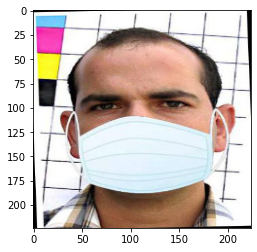

[0]
Probability:[[0.6771491  0.32285088]]
Wearing MASK


In [16]:
def predict_mask(path):
    im = cv2.imread(path)
    
    im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)
    
    plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
    plt.show()
    
     
    img_pred = image.load_img(path,target_size=(224,224))
    
    img_pred = image.img_to_array(img_pred)
    img = np.expand_dims(img_pred,axis=0)
    result = saved_model.predict_classes(img)
    prob = saved_model.predict_proba(img)
    print(result)
    print('Probability:{}'.format(prob))
    if result[0]==0:
        prediction ="Wearing MASK"
    else :
        prediction ="Not Wearing MASK"
    
 
    print(prediction)
 
 # Function calling 
predict_mask(r'C:\Users\Ayush maheshwari\test\test_images\augmented_image_311.jpg')


In [17]:
# messages on screen
resMap = {
        0 : 'Wearing',
        1 : 'Not Wearing',
        }
 
# Colors on screen
colorMap = {
        0 : (0,255,0),
        1 : (0,0,255),  
    }
 
def prepImg(pth):
    return cv2.resize(pth,(224,224)).reshape(1,224,224,3)/255.0
 
classifier = cv2.CascadeClassifier(r'C:\Users\Ayush maheshwari\HaarCascade\haarcascade_frontalface_default.xml')
 
cap = cv2.VideoCapture(0)
while True:
    ret,img = cap.read()
    faces = classifier.detectMultiScale(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY),1.1,2)
 
    for (x, y , w ,h) in faces:
        
        pred = saved_model.predict(prepImg(img))
        pred = np.argmax(pred)
        cv2.rectangle(img, (x,y), (x+w, y+h),colorMap[pred], 3)
        cv2.putText(img, resMap[pred],(x,y-5),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)        
         
                 
    cv2.imshow('FaceMask Detection',img)
    if cv2.waitKey(1) & 0xff == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
